In [17]:
import pickle

URL_PER_SITE = 10
TOTAL_URLS_MONITORED = 950
TOTAL_URLS_UNMONITORED = 3000

# Load monitored data
print("Loading monitored datafile...")
with open("./mon_standard.pkl", 'rb') as fi: # Path to mon_standard.pkl 
    monitored_data = pickle.load(fi)

X1_mon = [] # Array to store instances (timestamps)
X2_mon = [] # Array to store instances (direction*size)
y_mon = [] # Array to store the site of each instance

# x array (direction*timestamp), y array (site label)
for i in range(TOTAL_URLS_MONITORED):
    for sample in monitored_data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1_mon.append(time_seq)
        X2_mon.append(size_seq)
        y_mon.append(1)
mon_size = len(y_mon)

print(f'Total monitored samples: {mon_size}') # Output: 19000

Loading monitored datafile...
Total monitored samples: 19000


In [18]:
# Load unmonitored data
print("Loading unmonitored datafile...")
with open('./unmon_standard10_3000.pkl', 'rb') as fi:  # Path to unmon_standard10.pkl in Colab
    unmonitored_data = pickle.load(fi)

X1_unmon = [] # Array to store instances (timestamps)
X2_unmon = [] # Array to store instances (direction*size)
y_unmon = [] # Array to store the site of each instance

for i in range(TOTAL_URLS_UNMONITORED):
    size_seq = []
    time_seq = []
    for c in unmonitored_data[i]:
        dr = 1 if c > 0 else -1
        time_seq.append(abs(c))
        size_seq.append(dr * 512) # In the pickle file, there is no size information, so the conversion code is set to multiply by 512 uniformly.
    X1_unmon.append(time_seq)
    X2_unmon.append(size_seq)
    y_unmon.append(-1)
unmon_size = len(y_unmon)

print(f'Total unmonitored samples: {unmon_size}') # Output: 3000

Loading unmonitored datafile...
Total unmonitored samples: 3000


In [20]:
import pandas as pd

# Create the DataFrame from monitored data
df_mon = pd.DataFrame({
    'time_seq': X1_mon,  # Timestamps sequence
    'size_seq': X2_mon,  # Size sequence
    'label': y_mon       # Labels (site information)
})

df_unmon = pd.DataFrame({
    'time_seq': X1_unmon,  # Timestamps sequence
    'size_seq': X2_unmon,  # Size sequence
    'label': y_unmon       # Labels (site information)
})

# Check if the dataframe is created properly
print(f"monitored dataFrame size: {df_mon.shape}")
print(f"unmonitored dataFrame size: {df_unmon.shape}")

monitored dataFrame size: (19000, 3)
unmonitored dataFrame size: (3000, 3)


In [21]:
# Combine the two DataFrames
df_combined = pd.concat([df_mon, df_unmon], ignore_index=True)

# Check if the DataFrame is created properly
print(f"Combined DataFrame size: {df_combined.shape}")

Combined DataFrame size: (22000, 3)


In [22]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Extract Continuous Features
df_combined['cumulative_size'] = df_combined['size_seq'].apply(np.cumsum)  # Cumulative packet size
df_combined['burst_std'] = df_combined['size_seq'].apply(lambda x: np.std(np.diff(x, prepend=0)))  # Burst standard deviation
df_combined['mean_packet_size'] = df_combined['size_seq'].apply(np.mean)  # Mean packet size
df_combined['mean_timestamp'] = df_combined['time_seq'].apply(np.mean)  # Mean timestamp

# Extract Categorical Features
df_combined['num_incoming'] = df_combined['size_seq'].apply(lambda x: sum(1 for i in x if i < 0))  # Number of incoming packets
df_combined['num_outgoing'] = df_combined['size_seq'].apply(lambda x: sum(1 for i in x if i > 0))  # Number of outgoing packets
df_combined['total_packets'] = df_combined['num_incoming'] + df_combined['num_outgoing'] # Number of total packets
df_combined['fraction_incoming'] = df_combined['num_incoming'] / df_combined['total_packets']  # Fraction of incoming packets
df_combined['fraction_outgoing'] = df_combined['num_outgoing'] / df_combined['total_packets']  # Fraction of outgoing packets

In [23]:
# Add Features
df_combined['packetsize_std'] = df_combined['size_seq'].apply(lambda x: np.std(x))
df_combined['timestamp_std'] = df_combined['time_seq'].apply(lambda x: np.std(x))
df_combined['mean_outgoing_packets'] = df_combined['size_seq'].apply(lambda x: np.mean([i for i in x if i > 0]) if any(i > 0 for i in x) else 0)
df_combined['packet_concentration_ordering'] = df_combined['size_seq'].apply(lambda x: np.mean(np.diff(x)))

In [24]:
# Fill any NaN values
df_combined.fillna(0, inplace=True)

In [25]:
continuous_features = [
    'cumulative_size', 
    'burst_std', 
    'mean_packet_size', 
    'mean_timestamp',
    'packetsize_std', 
    'timestamp_std'
    ]
categorical_features = [
    'fraction_incoming', 
    'fraction_outgoing', 
    'total_packets', 
    'num_incoming', 
    'num_outgoing',
    'mean_outgoing_packets', 
    'packet_concentration_ordering'
    ]

In [26]:
# Flatten lists
X_continuous = np.array(df_combined[continuous_features].map(lambda x: np.mean(x) if isinstance(x, np.ndarray) else x))
X_categorical = df_combined[categorical_features].values
X = np.hstack([X_continuous, X_categorical])  # Combine continuous and categorical features
y = df_combined['label'].values  # Labels

In [27]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
# Standardize Continuous Features
scaler = StandardScaler()
X_train[:, :len(continuous_features)] = scaler.fit_transform(X_train[:, :len(continuous_features)])
X_test[:, :len(continuous_features)] = scaler.transform(X_test[:, :len(continuous_features)])

In [29]:
# Train the Model
clf = RandomForestClassifier( # 기본 설정
    n_estimators=100,
    max_depth=10,
    random_state=42,
    criterion='gini'
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [30]:
from sklearn.metrics import accuracy_score

# Evaluate the Model
report = classification_report(y_test, y_pred)
print(report)

accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy: {accuracy * 100:.2f}%")

              precision    recall  f1-score   support

          -1       0.85      0.09      0.17       882
           1       0.88      1.00      0.93      5718

    accuracy                           0.88      6600
   macro avg       0.86      0.55      0.55      6600
weighted avg       0.87      0.88      0.83      6600

accuracy: 87.67%


In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [100,200,300],  # 트리 개수
    'max_depth': [10,20,30],  # 트리의 최대 깊이
    'min_samples_split': [2],  # 분할을 위한 최소 샘플 수
    'min_samples_leaf': [1],    # 리프 노드에 대한 최소 샘플 수
    'random_state': [42, 123], 
    'criterion': ['gini', 'entropy']
}

# GridSearchCV로 하이퍼파라미터 튜닝 (교차 검증 포함)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# 훈련 데이터로 그리드 서치 수행
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print(f"Best parameters: {grid_search.best_params_}")

# 최적의 모델로 예측 수행
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate the Model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"accuracy: {accuracy_best * 100:.2f}%")
report_best = classification_report(y_test, y_pred_best)
print(report_best)

# 예측 확률값 (양성 클래스에 대한 확률)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba_best)
print(f"AUC Score: {auc_score:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=42; total time=   2.4s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=123; total time=   2.4s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=42; total time=   2.4s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=42; total time=   2.4s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=42; total time=   2.4s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=123; total time=   2.4s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=42; total time=   2.5

/var/folders/3q/h61ghnxn5bvgvc2r08ghgwkc0000gn/T/ipykernel_12564/1337943354.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier", color='gray')


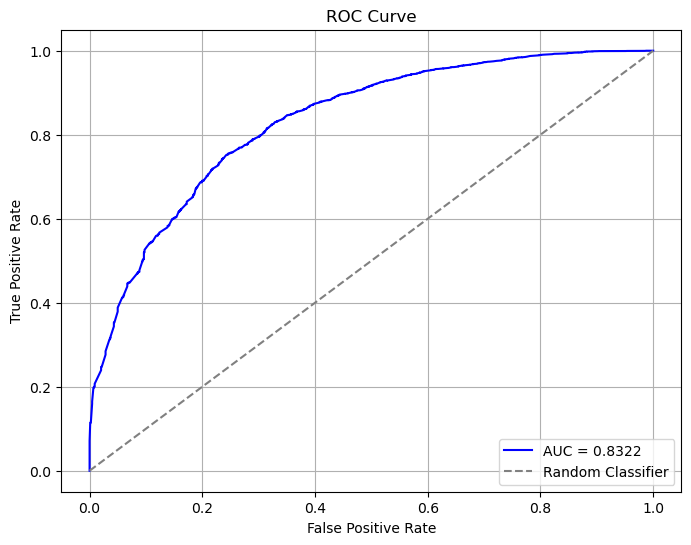

In [32]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# AUC ROC Curve 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)

# AUC ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier", color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [33]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_model, X, y, cv=5)
print(scores)
print(sum(scores)/len(scores))

[0.83272727 0.8225     0.81181818 0.85204545 0.82022727]
0.8278636363636362
